In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
 
# Define directories for training and testing datasets
train_dir = "D:/test rice/Rice diseases/Diseases"
test_dir = "D:/test rice/Rice diseases/upload"
 
# ImageDataGenerator for augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
 
test_datagen = ImageDataGenerator(rescale=1./255)
 
# Prepare train and test data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)
 
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for confusion matrix, to maintain order
)

Found 666 images belonging to 7 classes.
Found 225 images belonging to 7 classes.


In [2]:
# Load the pre-trained VGG16 model (without the top layers)
base_model = VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model
 
# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(train_data.num_classes, activation='softmax')  # Output layer
])
 
# Compile the model with Adam optimizer and categorical crossentropy loss
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
 
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
 
# Train the model
history = model.fit(
    train_data,
    epochs=30,
    validation_data=test_data,
    callbacks=[early_stopping]
)
 
# Evaluate the model on the test data
evaluation = model.evaluate(test_data)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

# Confusion Matrix
y_true = test_data.classes  # True labels from the test data
y_pred = np.argmax(model.predict(test_data), axis=-1)  # Predicted labels

C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2600 - loss: 2.3424 - val_accuracy: 0.5156 - val_loss: 1.2303
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4460 - loss: 1.4018 - val_accuracy: 0.6444 - val_loss: 0.9978
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5665 - loss: 1.2044 - val_accuracy: 0.7556 - val_loss: 0.7618
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5893 - loss: 1.1028 - val_accuracy: 0.7422 - val_loss: 0.8559
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6120 - loss: 1.0080 - val_accuracy: 0.7556 - val_loss: 0.7449
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6451 - loss: 0.9861 - val_accuracy: 0.8089 - val_loss: 0.6469
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6770 - loss: 0.9410 - val_accuracy: 0.7822 - val_loss: 0.6122
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7054 - loss: 0.8468 - val_accuracy: 0.8356 - val_loss:

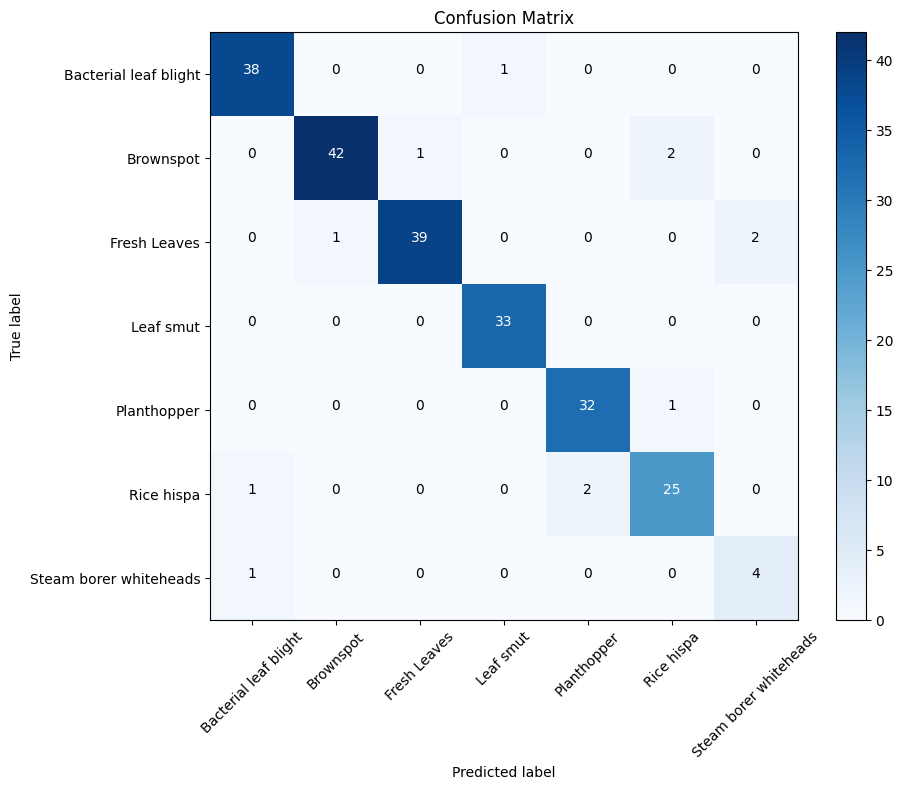

In [3]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
 
# Plot the confusion matrix using matplotlib directly
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
 
# Add class labels to x and y axis
class_names = list(test_data.class_indices.keys())
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
 
# Display the counts in each cell
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max()/2 else "black")
 
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to load and preprocess a specific image
def load_and_prep_image(img_path, img_size=128):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array, img

In [5]:
def predict_with_confidence(model, img_array, class_names, confidence_threshold=0.70):
    """
    Makes a prediction with confidence threshold.
    Returns the predicted class only if confidence is above threshold,
    otherwise returns "Unknown" or "Not a rice leaf".
    """
    # Get model predictions
    predictions = model.predict(img_array)
    # Get the highest confidence score
    max_confidence = np.max(predictions)
    # Get the index of the class with highest confidence
    predicted_class_index = np.argmax(predictions)
    
    # Check if confidence meets our threshold
    if max_confidence >= confidence_threshold:
        predicted_class = class_names[predicted_class_index]
        return predicted_class, max_confidence
    else:
        return "Not a rice leaf", max_confidence

# Function to visualize prediction with confidence
def display_prediction(img, predicted_class, confidence):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2%}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


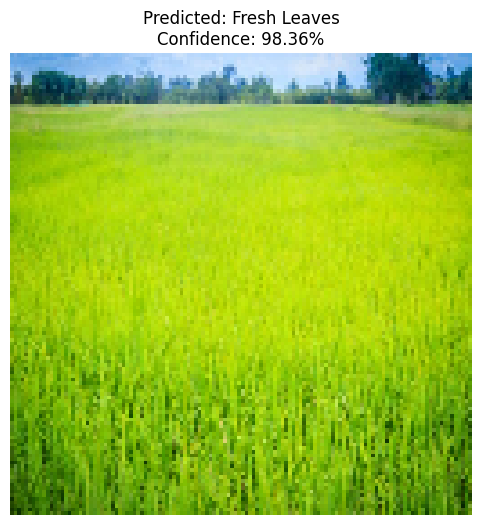

In [6]:
# Path to the specific test image (you can change this path)
img_path = 'D:/test rice/Rice diseases/upload/Fresh Leaves/360_F_250501979_jf2FVZefAP3OLabeoZRQYI21K7Sz7ZAg.jpg'

# Load and preprocess the image
img_array, img = load_and_prep_image(img_path)

# Get class names from the test dataset generator
class_names = list(test_data.class_indices.keys())

# Make prediction with confidence threshold
predicted_class, confidence = predict_with_confidence(model, img_array, class_names)

# Display the results
display_prediction(img, predicted_class, confidence)

In [7]:
def test_multiple_images(image_paths, model, class_names, confidence_threshold=0.70):
    """
    Tests the model on multiple images and displays results
    """
    plt.figure(figsize=(15, 10))
    num_images = len(image_paths)
    columns = 3
    rows = (num_images + columns - 1) // columns
    
    for i, img_path in enumerate(image_paths):
        # Load and preprocess the image
        img_array, img = load_and_prep_image(img_path)
        
        # Make prediction with confidence threshold
        predicted_class, confidence = predict_with_confidence(
            model, img_array, class_names, confidence_threshold
        )
        
        # Add to plot
        plt.subplot(rows, columns, i + 1)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2%}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage with multiple images
# Add paths to different images including non-rice leaves for testing
image_paths = [
    'D:/test rice/Rice diseases/upload/Planthopper/BPH1_6910f97c-761a-4adc-8a8c-d1bd0c580296.jpeg',
    # Add paths to other rice leaf images
    # Add paths to non-rice leaf images (mango, etc.)
]
# Save the entire model to a HDF5 file
model.save('model.h5')
